In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# For inline plotting in notebooks (if needed):
# %matplotlib inline

##############################################
# In this tutorial, we'll use a simple linear model to learn
# the conversion from thermometer readings in unknown units (t_u)
# to temperatures in Celsius (t_c). We will split the data into
# training and validation sets to monitor overfitting.
##############################################


In [2]:
def model(t_u, w, b):
    """
    Linear model: predicted Celsius = w * t_u + b
    """
    return w * t_u + b

def loss_fn(t_p, t_c):
    """
    Mean Squared Error (MSE) loss: average((t_p - t_c)^2)
    """
    return ((t_p - t_c)**2).mean()

##############################################
# These functions define our model and the loss.
# Our goal is to adjust w (weight) and b (bias) to minimize the loss.
##############################################


In [3]:
# Temperature in Celsius (t_c) and thermometer readings (t_u) in unknown units.
t_c_list = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u_list = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

# Convert to PyTorch tensors of type float
t_c = torch.tensor(t_c_list, dtype=torch.float)
t_u = torch.tensor(t_u_list, dtype=torch.float)

##############################################
# t_c and t_u are now 1D tensors of shape [11].
##############################################


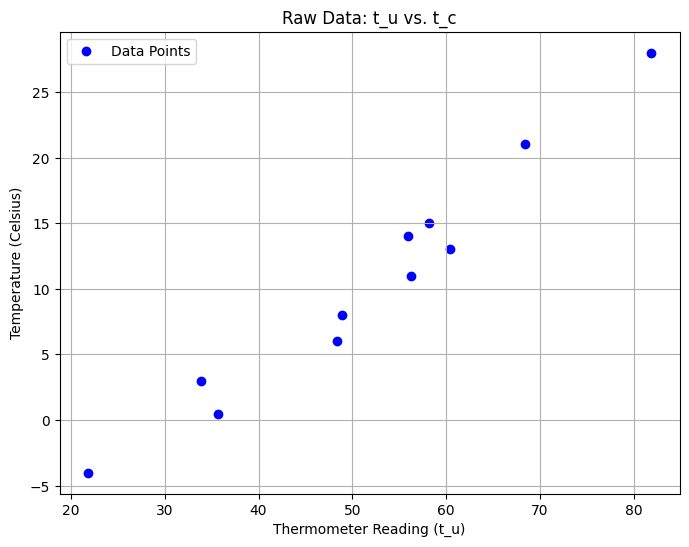

In [4]:
plt.figure(figsize=(8,6))
plt.scatter(t_u.numpy(), t_c.numpy(), color='blue', label='Data Points')
plt.xlabel("Thermometer Reading (t_u)")
plt.ylabel("Temperature (Celsius)")
plt.title("Raw Data: t_u vs. t_c")
plt.legend()
plt.grid(True)
plt.show()

##############################################
# The scatter plot should show a roughly linear relationship.
##############################################


In [5]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)  # 20% of data for validation
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

print("Training indices:", train_indices)
print("Validation indices:", val_indices)

##############################################
# Expected output: Two tensors of indices. For example, training indices might be:
# tensor([ 8, 0, 3, 6, 4, 1, 2, 5, 10])
# and validation indices might be:
# tensor([9, 7])
##############################################


Training indices: tensor([ 6,  0, 10,  1,  9,  8,  5,  2,  7])
Validation indices: tensor([3, 4])


In [6]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]
val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

# Normalize the unknown units by scaling by 0.1 (this helps gradient stability)
train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

##############################################
# Now, train_t_un and val_t_un are the normalized versions of t_u.
##############################################


In [7]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    """
    Train the model while monitoring training and validation loss.
    
    Args:
      n_epochs: Number of epochs to run.
      optimizer: PyTorch optimizer to update parameters.
      params: Tensor containing the parameters [w, b] (with requires_grad=True).
      train_t_u, train_t_c: Training data (inputs and targets).
      val_t_u, val_t_c: Validation data (inputs and targets).
    
    Returns:
      The updated parameters and a record of losses.
    """
    train_losses = []
    val_losses = []
    for epoch in range(1, n_epochs + 1):
        # Forward pass on training data
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        train_losses.append(train_loss.item())
        
        # Forward pass on validation data (no backward pass here)
        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)
        val_losses.append(val_loss.item())
        
        # Zero gradients, backward pass, and parameter update
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # Logging: print losses every 500 epochs or during the first few epochs
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.6f}, Validation loss {val_loss.item():.6f}")
            
    return params, train_losses, val_losses

##############################################
# Explanation:
# This loop performs:
#  - A forward pass on the training and validation sets.
#  - A backward pass on the training loss only.
#  - An optimizer step to update the parameters.
# It logs both training and validation losses.
##############################################


In [8]:
params = torch.tensor([1.0, 0.0], dtype=torch.float, requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

##############################################
# We use SGD with a learning rate of 1e-2. Make sure your parameters have requires_grad=True.
##############################################


In [9]:
n_epochs = 3000
trained_params, train_losses, val_losses = training_loop(
    n_epochs=n_epochs,
    optimizer=optimizer,
    params=params,
    train_t_u=train_t_un,
    val_t_u=val_t_un,
    train_t_c=train_t_c,
    val_t_c=val_t_c
)

print("Final trained parameters:", trained_params.detach().numpy())

##############################################
# Expected output:
# - The training and validation loss should both decrease over time.
# - If validation loss starts to diverge from training loss, overfitting may be occurring.
##############################################


Epoch 1, Training loss 51.414974, Validation loss 210.636475
Epoch 2, Training loss 30.883659, Validation loss 122.450356
Epoch 3, Training loss 26.059856, Validation loss 89.789841
Epoch 500, Training loss 7.685292, Validation loss 20.793468
Epoch 1000, Training loss 3.951566, Validation loss 8.951225
Epoch 1500, Training loss 3.137883, Validation loss 5.430295
Epoch 2000, Training loss 2.960561, Validation loss 4.224077
Epoch 2500, Training loss 2.921917, Validation loss 3.756302
Epoch 3000, Training loss 2.913496, Validation loss 3.558726
Final trained parameters: [  5.1676326 -16.268568 ]


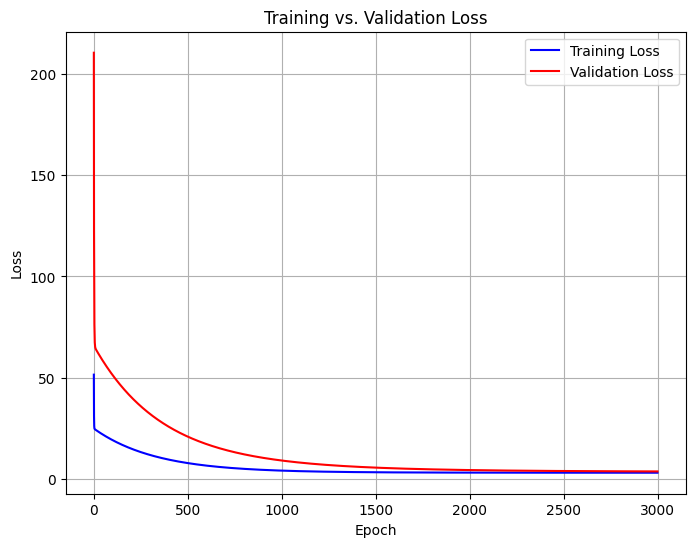

In [10]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

##############################################
# Explanation:
# The plot shows how loss changes over epochs. Ideally, both training and validation
# losses decrease together. A divergence (training loss decreases but validation loss increases)
# indicates overfitting.
##############################################
